***
***

# Examining the Utility of Diffusion Profiles
***

**Authors:** [TJCallahan](https://mail.google.com/mail/u/0/?view=cm&fs=1&tf=1&to=callahantiff@gmail.com)

|                                             **GitHub Repositories**                                            |                                                               **Documentation**                                                              |   |   |   |
|:--------------------------------------------------------------------------------------------------------------:|:--------------------------------------------------------------------------------------------------------------------------------------------:|---|---|---|
| [Multiscale Interactome and Diffusion Profiles GitHub](https://github.com/callahantiff/multiscale-interactome) | [Diffusion Profile Manuscript Summary](https://docs.google.com/presentation/d/1c0e9hZrcPyK4jz5ae7hdfrFcJMMRERwnK8bz4TNtO-A/edit?usp=sharing) |   |   |   |
| [PheKnowLator](https://github.com/callahantiff/multiscale-interactome/tree/development)                        | [Planned Experiments](https://docs.google.com/document/d/1wjEgJK3wkHB-h_fIIg5mM2JtVJ7ts9alrHIKTOklb_Q/edit#)                                 |   |   |   |
|                                                                                                                | [Validation Data/Results](https://docs.google.com/spreadsheets/d/1Uw-50AAhYS7GCz_7EsKHD8nUsiqTjJCuKQvfaqzaEqw/edit#gid=1173356993)           |   |   |   |

<br>

  
### Notebook Objective   
***
**Background**  
Despite decades of research, the majority of adverse events and side effects are not known or discovered until after they are observed ([`PMID:20803507`](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3057924/)). Systems pharmacology aims to describe the effects of a drug at the molecular level, by integrating data from multiple temporal and spatial scales across all levels of biological organization ([`PMID:27251780`](https://pubmed.ncbi.nlm.nih.gov/27251780/)). These data are usually represented as a network or knowledge graph (KG), where nodes are biological entities (e.g., chemical compounds, proteins) and edges indicate relationships between these entities (e.g., interactions, drug-target affinity) [`PMID:25670520`](https://pubmed.ncbi.nlm.nih.gov/25670520/). Systems pharmacology models have successfully predicted drug side effects, developed precision therapeutics, and facilitated drug repurposing. While promising, the majority of these models focus on understanding the effects of single entities (e.g., a single drug, indication, or protein target) excluding important biological context, which may result in biased models and conclusions that are not biologically plausible ([`PMID:26559926`](https://pubmed.ncbi.nlm.nih.gov/26559926/), [`PMID:27814027`](https://pubmed.ncbi.nlm.nih.gov/27814027/)).

Recently, researchers from Stanford University built software ([`PMID:33741907`](https://pubmed.ncbi.nlm.nih.gov/33741907/)) that constructs a simple graph (i.e., multiscale interactome), which contained 17,660 human proteins, 9,798 biological processes, 1,661 drugs, and 840 diseases. The authors also developed code that leverages this graph to generate diffusion profiles which are created using a biased random walk-based method built off of Page Rank, "that captures how drug effects propagate through a hierarchy of biological functions and physical protein-protein interactions".

The goal of this work was two-fold:  
1. Implement the code to build the musltiscale interactome and using it, generate diffusion profiles. During the process, make any necessary edits or modifications to the codebase to improve it.  
2. Conduct experiments designed to explore the resulting diffusion profiles and examine their utility for use in causal applications and adverse drug event detection.  

**Objective**  
The value of the diffusion profiles will be compared to traditional network science-based measures of topology. As an example, we will compare the value of each of these different approaches when applied to **lisinopril** (`DrugBank:DB00722`) and **coughing** (`UMLS:C0010200`).
<!-- The objective of the experiments are to explore different ways of leveraging the diffusion profiles with the goal of determining how well they do at recovering known negative controls and side effects from the OHDSI Legacy Hypertension Study and the literature for a particular drug and side effect. More details are provided in the *Case Study* section of this notebook. !-->

<br>



### Notebook Organization  <a class="anchor" id="toc"></a>   
***
* [Global Environment Set-Up](#set-up)  
* [Build Multiscale Interactome](#build-msi)  
* [Generate Diffusion Profiles](#generate-diffusion-profiles)
* [Descriptive Statistics](#descriptive-stats)  
* [Case Study](#case-study)  
  * [Network Topology](#network-topology)  
  * [Diffusion Profiles](#diffusion-profiles)

<br>  


### Generated Output
***
#### Created Data Structures  
The following structures were created and analyzed for the experiments in this notebook:  
- *Diffusion Profiles*
  - `results/msi_diffusion_profile_matrix.npy`  
  - `results/msi_diffusion_profile_matrix_adjusted.npy`
- *Mulitscale Interactome Graph*  
  - `results/msi_diffusion_profile_matrix_index_ids.npy`  
  - `results/msi_diffusion_profile_matrix_index_ids.npy`  
  - `results/msi_graph_node2name.pkl`
  - `results/msi_graph_node2type.pkl`  
  - `results/msi_graph.pkl` 
- *Experiment Results*  
  - `experiments/experiment1_similarity_overlap_selfimp_top1000.tsv`   
  - `experiments/experiment1_similarity_overlap_selfimp_all.tsv`   
  - `experiments/experiment1_similarity_overlap_noselfimp_top1000.tsv`   
  - `experiments/experiment1_similarity_overlap_noselfimp_all.tsv`   

<br>

<!--
#### Validation Data
All concepts referenced below will be mapped to `UMLS` concepts so their identifiers are compatible with the disease identifiers used in the graph.
- Negative Controls (filtered for Hypertension) → [here](https://github.com/OHDSI/Legend/blob/master/inst/settings/NegativeControls.csv)
  - Spreadsheet Tab: `lisinopril_negative_controls` ([here](https://docs.google.com/spreadsheets/d/1Uw-50AAhYS7GCz_7EsKHD8nUsiqTjJCuKQvfaqzaEqw/edit?usp=sharing))
- Known side effects (shown below, from Mayo clinic [here](https://www.mayoclinic.org/drugs-supplements/lisinopril-oral-route/side-effects/drg-20069129?p=1) and at UpToDate [here](https://www.uptodate.com/contents/major-side-effects-of-angiotensin-converting-enzyme-inhibitors-and-angiotensin-ii-receptor-blockers#H939716))
  - Spreadsheet Tab: `lisinopril_known_side_effects` ([here](https://docs.google.com/spreadsheets/d/1Uw-50AAhYS7GCz_7EsKHD8nUsiqTjJCuKQvfaqzaEqw/edit?usp=sharing))
!-->

***
***

<br>
<br>

## Global Environment Set-Up  <a class="anchor" id="set-up"></a>  
***
This section helps set-up the coding environment by loading needed Python libraries and applies global settings for plotting. This section also includes code to load the data structures that will be analyzed. Please see the [`main.py`](https://github.com/callahantiff/multiscale-interactome/blob/master/main.py) file in the `multiscale-interactome` GitHub for more information on the code that was used to create the data structures.


In [1]:
import sys
sys.path.append('../')

**Download and Load Libraries**  
These code chunks download, install, and load the Python libraries required to run the code in this Notebook.

In [2]:
%%capture
# download required libraries
!python -m pip install -r requirements.txt

In [3]:
# import and load needed scripts
import matplotlib.patches as mp
import matplotlib.pyplot as plt
import multiprocessing
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
import urllib.request as urllib
import zipfile

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from diff_prof.diffusion_profiles import *
from msi.msi import *
from utilities import *

# plot settings
%matplotlib inline
plt.style.use('ggplot')

<br>
<br>

## Build Multiscale Interactome  <a class="anchor" id="build-msi"></a>  
***
The multiscale interactome was constructed to contain 1661 drugs, 17660 proteins, 840 diseases, and 9798 biological processes. A figure depicting these data and additional detail on each of the primary edge types is provided below.  

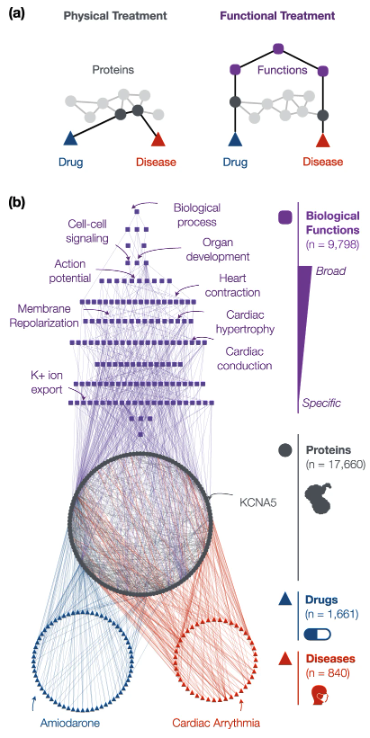


### Multiscale Interactome Data  
***
**Drug-Protein (n=8,568):**
- <u>Source(s)</u>: 
  - [DrugBank](https://go.drugbank.com/) (`v5.1.1; 2018`; `drugbank_approved_target_uniprot_links.csv`)
  - [Drug Repurposing Hub](https://clue.io/repurposing) (`September 2018`)
- <u>Processing</u>: map Uniprot to Entrez gene using [HUGO](https://www.genenames.org/) (October 2018) and drug ids to DrugBank ids
- <u>Filtering</u>: Filter proteins to only keep those that appear in the Protein-Protein edge set.

**Disease-Protein (n=25,212):**
- <u>Source(s)</u>: [DisGeNet](https://www.disgenet.org/) (`March 2018`)
- <u>Filtering</u>: only keep only expert curated gene-disease associations. (1) exclude disease-gene relationships that are inferred, based on orthology, animal models, or literature mining; (2) remove therapeutic disease-gene associations; and (3) remove disease-gene relationships that do not appear in the Protein-Protein edge set.

**Protein-Protein (n=387,626):**
- <u>Source(s)</u>:
  - [BioGRID](https://thebiogrid.org/) (`v3.5.178`; `November 2019`; `BIOGRID-ORGANISM-Homo_sapiens-3.5.178.tab`)
  - [Database of Interacting Proteins](https://dip.doe-mbi.ucla.edu/dip/Main.cgi) (`February 2017`; `Hsapi20170205.txt`). Include all experimental methods
  - [Human Reference Protein Interactome Mapping Project](http://www.interactome-atlas.org/). Four networks derived from high-throughput yeast two hybrid assays.
  - Menche 2015 ([PMID:25700523](http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?cmd=Retrieve&db=PubMed&dopt=Abstract&list_uids=25700523)). Compiles different types of physical protein-protein interactions.
- <u>Processing</u>: Map protein ids to Entrez gene ids using HUGO (sources 1-2 only)
- <u>Filtering</u>: only human proteins with physical interactions and direct experimental evidence (no genetic/indirect)

**Protein-Biological Process (n=34,777):**
Source(s)</u>: [Gene Ontology](http://geneontology.org/) (human; `February 2018`)
- <u>Processing</u>: use master ids provided by GOATOOLS (`v0.8.4`)
- <u>Filtering</u>: only allow: EXP, IDA, IMP, IGI, HTP, HDA, HMP, HGI. Exclude any protein-biological functions inferred from: physical interactions, gene expression patterns, phylogenetically inferred annotations or computational analyses, automatic annotations (i.e., based on author statements, curator inference, electronic annotation), and those with no biological data

**Biological Process-Biological Process (n=22,545):**
- <u>Source(s)</u>: [Gene Ontology](http://geneontology.org/) (human; `February 2018`) + Gene Ontology Plus (human version; `July 2020`)
- <u>Filtering</u>: Allow following relationship types: regulates, positively regulates, negatively regulates, part of, is a. Only consider BPs associated with at least one drug target or disease protein (directly or through children)

<br>

**Dependencies**  
*Data*  
All data is provided at http://snap.stanford.edu/multiscale-interactome/data/data.tar.gz and includes:
- Supplementary dataset of interactions between drugs and proteins
- Supplementary dataset of interactions between diseases and proteins
- Supplementary dataset of interactions between proteins and proteins
- Supplementary dataset of interactions between proteins and biological functions
- Supplementary dataset of hierarchy of interactions between biological functions
- Supplementary dataset of approved drug-disease pairs
- Supplementary dataset of drug classes according to Anatomical Therapeutic Chemical Classification
- Supplementary dataset of selected gene expression signatures from the Broad Connectivity Map
- Supplementary dataset of genes that alter drug response from PharmGKB
- Supplementary dataset of optimized diffusion profiles

Before running the code below, make sure to downloaded the data and put the files in the `resources/data/` directory.
<br>

*** 

### ⚠️ Updates to Original Implementation  ⚠️  
*Modifications to Original Data and Code*
- Ensured every entry had a valid identifier and label
- Reconciled duplicate gene entries (i.e., gene identifiers that had been merged)
- Changed genes are listed in: `resources/data/updated_gene_identifiers.xlsx`

*Modified Output*
- `msi_graph.pkl`: Networkx graph representation of the multi-scale interactome
- `results/msi_graph_node2name.pkl`: Dict containing mappings between node ids and labels
- `results/msi_graph_node2type.pkl`: Dict containing mappings between node ids and type
- `results/msi_graph_node2idx.pkl`: Dict containing mappings between node ids and enumerated index

**Download Modified Data**  
The code chunk below downloaded the revised data required to build the multiscale interactome. The data are downloaded from Zenodo (https://zenodo.org/record/7819798#.ZDXlO-zMJlo) and unzipped to `resources/data`.

In [72]:
# download and extract data only if it has not already been downloaded
data_file_path = '../resources/data/'
url = 'https://zenodo.org/record/7819798/files/data.zip?download=1'

if not os.path.exists(data_file_path[:-1]):
    filehandle, _ = urllib.urlretrieve(url)
    with zipfile.ZipFile(filehandle, 'r') as z:
        z.extractall(path='/'.join(data_file_path.split('/')[0:2]))

**Build Multiscale Interactome**  
The code chunks below uses the downloaded data to build the multiscale interactome described above.

In [9]:
# set paths to data files
core_dir = "../resources/data/"
drug2protein_file_path = core_dir + "1_drug_to_protein.tsv"
indication2protein_file_path = core_dir + "2_indication_to_protein.tsv"
protein2protein_file_path = core_dir + "3_protein_to_protein.tsv"
protein2biological_function_file_path = core_dir + "4_protein_to_biological_function.tsv"
biological_function2biological_function_file_path = core_dir + "5_biological_function_to_biological_function.tsv"
save_load_file_path='../results/'

In [10]:
# construct the multiscale interactome
msi = MSI(drug2protein_directed=False, indication2protein_directed=False, protein2protein_directed=False,
          protein2biological_function_directed=False, biological_function2biological_function_directed=True,
          drug2protein_file=drug2protein_file_path, indication2protein_file=indication2protein_file_path, protein2protein_file=protein2protein_file_path,
          protein2biological_function_file=protein2biological_function_file_path,
          biological_function2biological_function_file=biological_function2biological_function_file_path,
          save_load_file_path=save_load_file_path)
msi.load()



****************************************************************************************************
Constructing Multi-Scale Interactome
****************************************************************************************************
---> Loading Data
	- Processing Drug-Protein Data
	- Processing Indication-Protein Data
	- Processing Protein-Protein Data
	- Processing Protein-Biological Process Data
	- Processing Biological Process-Biological Process Data
---> Creating Node Indexes, Types, and Labels
---> Obtaining Drugs in Graph
---> Obtaining Indications in Graph
---> Obtaining Protein Neighborhoods for Drugs and Indications
---> Saving Multi-Interactome and Node Metadata Dictionaries


<br>
<br>

## Generate Diffusion Profiles  <a class="anchor" id="generate-diffusion-profiles"></a>  
***
As noted in the manuscript, **Diffusion profile** is computed by biased random walks that start at the drug or disease node. At every step, the walker can restart its walk or jump to an adjacent node based on optimized edge weights. More specifically:

> To identify how a drug treats a disease, our approach uses biased random walks which model how drug effects spread through a hierarchy of biological functions and are coordinated by the protein–protein interaction network in which drugs act. In the multiscale interactome, drugs treat diseases by propagating their effects through a network of physical interactions between proteins and a hierarchy of biological functions. For each drug and disease, we learn a diffusion profile, which identifies the key proteins and biological functions involved in a given treatment. By comparing drug and disease diffusion profiles, the multiscale interactome provides an interpretable basis to identify the proteins and biological functions that explain successful treatments. ([`PMID:33741907`](https://pubmed.ncbi.nlm.nih.gov/33741907/))


### Algorithm Details
***Matrix formulation with power iteration***  
*Inputs*
- $G = (V, E)$; unweighted and undirected graph
- $W = [w_{drug}, w_{disease}, w_{protein}, w_{BP}, w_{high-level BP}, w_{low-level BP}]$ - relative likelihood of walker jumping to different node type
- $⍺$ - probability of the walker continuing its walk at a given step or restarting
- $s ∈ ℝ∣𝑉∣$ a restart vector which sets the probability the walker will jump to each node after a restart
- $s$ - is a one-hot vector encoding of the disease or drug of interest
- $ϵ$ - tolerance allowed for convergence of power iteration computation

*Outputs*
 - $𝐫 ∈ ℝ∣𝑉∣$ - drug or disease diffusion profile which measures the frequency the walker visited each node
 
 <br>
 
***


### ⚠️ Updates to Original Implementation and Output ⚠️  
*Modifications to Original Data and Code*  
- Significantly overhauled code to include docstrings and typing for all functions
- Updated diffusion profile class to generate a diffusion profile for all graph entities. Added new functionality to process output diffusion profiles into a multidimensional numpy array

*Updated Diffusion Profile Output*
- `results/msi_diffusion_profile_matrix.npy`: Multidimensional numpy array where each row is an individual node’s diffusion profile with length equal to the number of nodes in the graph (n=29,902)
- `results/msi_diffusion_profile_matrix_index_ids.npy`: Dict containing mapping between node index in numpy array and node id

<br>

**Example Diffusion Profile**  
The diffusion profile matrix row and column indexes both follow the node order specified in `msi.nodelist`  
$node1 = array([1.23087825e-08, 1.33437834e-07, 3.78419739e-08, ..., 3.53442153e-06])$


In [11]:
# set inputs with default values according to README instructions
alpha = 0.8595436247434408
weight_dict = {
    "down_biological_function":  4.4863053901688685,
    "indication": 3.541889556309463,
    "biological_function": 6.583155399238509,
    "up_biological_function": 2.09685000906964,
    "protein": 4.396695660380823,
    "drug": 3.2071696595616364
}
# determine number of cores to use for parallel processing
available_cores = int(multiprocessing.cpu_count() / 2) - 4
cores = available_cores if available_cores > 0 else 1
save_load_file_path='../results/'

In [12]:
# build diffusion profiles
dp = DiffusionProfiles(alpha=alpha, max_iter=1000, tol=1e-06, weights=weight_dict, num_cores=cores,
                       save_load_file_path=save_load_file_path)
dp.calculate_diffusion_profiles(msi)



****************************************************************************************************
Calculating Diffusion Profiles
****************************************************************************************************
---> Building and Weighting Adjacency Matrix
---> Building Adjacency Matrix for all Nodes in Graph
---> Weighting Edges
---> Preparing to Run Power Iteration
---> Running Power Iteration in Parallel


  0%|          | 1/29902 [00:00<1:07:18,  7.40it/s]

---> Running Power Iteration in Parallel


100%|██████████| 29902/29902 [1:29:59<00:00,  5.54it/s]  


---> Converting Node's Diffusion Profiles into a Single Diffusion Profile Matrix


100%|██████████| 29902/29902 [01:00<00:00, 490.43it/s]


Saving diffusion profile matrix (../results/msi_diffusion_profile_matrix.npy) and node index dictionary (../results/msi_diffusion_profile_matrix_index_ids.npy)

********** Diffusion Profile Runtime: 1:32:41.239314**********


In [72]:
# remove self-importance from each node's diffusion profile
dp_matrix_adj = remove_self_importance(dp_matrix, node_idx_dict)

100%|██████████| 29902/29902 [05:02<00:00, 98.88it/s]  


 <br>
 
 *** 
 ***
**<p style="text-align: center;">👉 Please click [here](#toc) to return to the top of the Notebook.</p>**
 ***  
 ***
 <br>

<br>
<br>

## Descriptive Statistics  <a class="anchor" id="descriptive-stats"></a>  
***  
This section presents the results from calculating statistics on the multiscale interactome graph and on the diffusion profiles which were generated from the graph. 

#### Load Analysis Data  
Load data created by building the multiscale interactome and generating the diffusion profiles.

In [5]:
# read in analysis data
dp_matrix = np.load("../results/msi_diffusion_profile_matrix.npy")
# dp_matrix_adj = np.load("../results/msi_diffusion_profile_matrix_adjusted.npy")
node_idx_dict = pickle.load(open("../results/msi_diffusion_profile_matrix_index_ids.npy", "rb"))
node_labels = pickle.load(open("../results/msi_graph_node2name.pkl", "rb"))
node_types = pickle.load(open("../results/msi_graph_node2type.pkl", "rb"))
msi_graph = pickle.load(open("../results/msi_graph.pkl", "rb"))

#### Graph Overview  <a class="anchor" id="graph-overview"></a>

In [5]:
print('The graph has {} edges'.format(len(msi_graph.edges())))

The graph has 957050 edges


In [6]:
# get counts of edges by edge type
keys = [['drug', 'protein'], ['indication', 'protein'], ['protein', 'protein'],
        ['protein', 'biological_function'], ['biological_function', 'biological_function']]
for k1, k2 in keys:
    cnt1, cnt2 = set(), set()
    for i, j in msi_graph.edges():
        if k1 in node_types[i] and k2 in node_types[j]:
            cnt1 |= {'{}-{}'.format(i, j)}
    print('EDGE TYPE: {} - {}: {} edges'.format(k1, k2, str(len(cnt1))))


EDGE TYPE: drug - protein: 8568 edges
EDGE TYPE: indication - protein: 25212 edges
EDGE TYPE: protein - protein: 774846 edges
EDGE TYPE: protein - biological_function: 34777 edges
EDGE TYPE: biological_function - biological_function: 45090 edges


In [7]:
print('The graph has {} nodes'.format(len(msi_graph.nodes())))

The graph has 29902 nodes


In [8]:
# get counts of nodes by node type
cnt = set()
keys = ['drug', 'indication', 'protein', 'biological_function']
for k in keys:
    cnt = set()
    for i, j in msi_graph.edges():
        if k in node_types[i]:
            cnt |= {i}
    print('NODE TYPE: {}: {} edges'.format(k, str(len(cnt))))

NODE TYPE: drug: 1661 edges
NODE TYPE: indication: 840 edges
NODE TYPE: protein: 17603 edges
NODE TYPE: biological_function: 9798 edges


#### Degree  <a class="anchor" id="degree"></a>

In [58]:
degree_list = [x[1] for x in list(msi_graph.degree())]
gets_simple_statistics(degree_list, "msi graph", "degree")

Statistics (msi graph, degree):
  - min=2; max=4600; median=18.0; mean=64.01244063942211


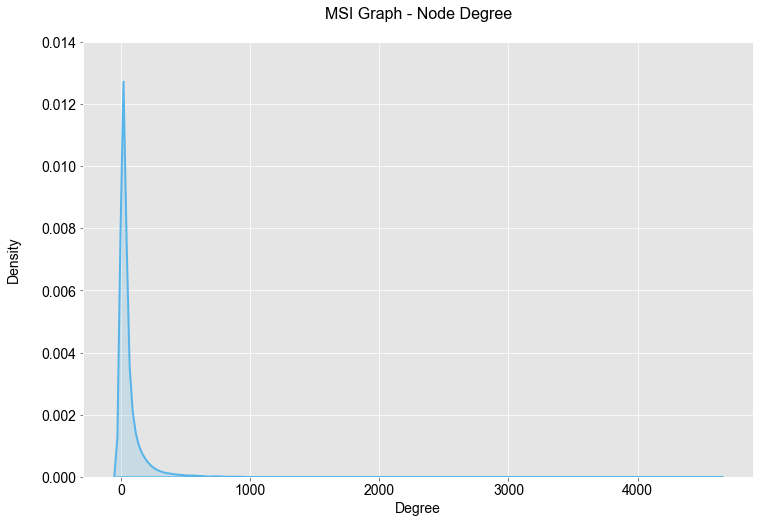

In [10]:
# create kernel density estimate plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
y = sns.kdeplot(degree_list, color='#56B4E9', label='Degree', shade=True, linewidth=2, alpha=0.2)
plt.title('MSI Graph - Node Degree\n', fontsize=16, fontname="Arial", color='black')
plt.suptitle('')
plt.xlabel('Degree', fontsize=14, fontname="Arial", color='black')
plt.ylabel('Density\n', fontsize=14, fontname="Arial", color='black')
plt.ylim(0.0, 0.014)
plt.tick_params(labelsize=14)
plt.yticks(color='black', fontname="Arial", fontsize=14)
plt.xticks(color='black', fontname="Arial", fontsize=14)
plt.show()

 <br>
 
 *** 
 ***
**<p style="text-align: center;">👉 Please click [here](#toc) to return to the top of the Notebook.</p>**
 ***  
 ***
 <br>

<br><br>


## Case Study  <a class="anchor" id="case-study"></a>  
***  
This section will examine the value of the diffusion profiles and compare them to using traditional network science-based measure of topology. As an illustration, we will compare the value of each of these different approaches when applied to **lisinopril** (`DrugBank:DB00722`) and **coughing** (`UMLS:C0010200`).

In [36]:
# lisinopril (DB00722)
lisinopril_concept_id = [k for k, v in node_labels.items() if v.lower() == "lisinopril"][0]
lisinopril_index = [k for k, v in node_idx_dict.items() if v == lisinopril_concept_id][0]

# cough (C0010200)
cough_concept_id = [k for k, v in node_labels.items() if v.lower() == "coughing"][0]
cough_index = [k for k, v in node_idx_dict.items() if v == cough_concept_id][0]

<br>

## Network Topology  <a class="anchor" id="network-topology"></a>
The goal of this section is to use network topology-based measures to determine the relationship between lisinopril and coughing.

**Topology Measures**
- <u>Shortest Paths</u>: Get all shortest paths that exist between two nodes (may need to treat graph as undirected)  
- <u> Simple Paths</u>: Get all paths of length $n$ that exist between two nodes without repeating any nodes in the path.
- <u>Efficency</u>: A measure of how efficiently information is exchanged between nodes, which ranges between 0-1

In [12]:
# create undirected version of graph
undirected_msi_graph = nx.to_undirected(msi_graph)

*Lisinopril's Neighborhood*

In [13]:
nodes_o = list(msi_graph.neighbors(lisinopril_concept_id))
out_neighbors = [[node_labels[lisinopril_concept_id], node_labels[n]] for n in nodes_o]
out_neighbors

[['lisinopril', 'ACE'], ['lisinopril', 'ACE2']]

*Coughing's Neighborhood*

In [14]:
nodes_o = list(msi_graph.neighbors(cough_concept_id))
out_neighbors = [[node_labels[cough_concept_id], node_labels[n]] for n in nodes_o]
out_neighbors

[['Coughing', 'CD79A'],
 ['Coughing', 'CD79B'],
 ['Coughing', 'CTLA4'],
 ['Coughing', 'ACE'],
 ['Coughing', 'GBA'],
 ['Coughing', 'HLA-DPB1'],
 ['Coughing', 'HLA-DRB1'],
 ['Coughing', 'IGHM'],
 ['Coughing', 'IGLL1'],
 ['Coughing', 'KNG1'],
 ['Coughing', 'MARS'],
 ['Coughing', 'PIK3R1'],
 ['Coughing', 'PRTN3'],
 ['Coughing', 'RNF6'],
 ['Coughing', 'STAT3'],
 ['Coughing', 'TCF3'],
 ['Coughing', 'TGFBR2'],
 ['Coughing', 'TSC1'],
 ['Coughing', 'TSC2'],
 ['Coughing', 'DLEC1'],
 ['Coughing', 'PTPN22'],
 ['Coughing', 'BLNK'],
 ['Coughing', 'WWOX']]

<br>

**Shortest Paths**

In [15]:
# function to get shortest path between two nodes
s = lisinopril_concept_id; t = cough_concept_id
try:
    kg_orientation = msi_graph; ind = 'directed'
    spl_d = nx.shortest_path_length(msi_graph, source=s, target=t)  
    print('The shortest path length is: {} ({})'.format(str(spl_d), ind))
    # get efficiency (measure of how efficiently information is exchanged between nodes)
    eff = nx.efficiency(undirected_msi_graph, s, t)
    print('The efficiency between the nodes is: {}'.format(str(eff)))
except nx.NetworkXNoPath:
    print('There is no path between {} and {}'.format(str(s), str(t)))
    kg_orientation = undirected_msi_graph; ind = 'undirected'
    spl_d = nx.shortest_path_length(undirected_msi_graph, source=s, target=t)
    print('The shortest path length is: {} ({})'.format(str(spl_d), ind))

The shortest path length is: 2 (directed)
The efficiency between the nodes is: 0.5


In [16]:
shortest_paths1 = list(nx.all_shortest_paths(kg_orientation, s, t))
p_len = nx.shortest_path_length(kg_orientation, source=s, target=t)
v = 'is' if len(shortest_paths1) == 1 else 'are'
print('There {} {} shortest paths of length {}'.format(v, str(len(shortest_paths1)), str(p_len)))

There is 1 shortest paths of length 2


In [17]:
for path in shortest_paths1:
    print('*' * 100)
    for i in range(0, len(path) - 1):
        print('{}, {}'.format(node_labels[path[i]], node_labels[path[i + 1]]))
    print('*' * 100)

****************************************************************************************************
lisinopril, ACE
ACE, Coughing
****************************************************************************************************


<br>

**Simple Paths**

In [18]:
# simple paths (i.e., no repeated nodes)
simple_paths1 = []; counter = 0; simple_path_len = 4
for path in tqdm(nx.all_simple_paths(kg_orientation, source=s, target=t, cutoff=simple_path_len)):
    simple_paths1 += [path]
#     if counter == 24: break
#     else: counter += 1

# print results
v = 'is' if len(simple_paths1) == 1 else 'are'
print('There {} {} simplest paths of length {}'.format(v, str(len(simple_paths1)), str(simple_path_len)))

58it [00:00, 211.15it/s]

There are 58 simplest paths of length 4


In [19]:
# shuffle order of paths
random.shuffle(simple_paths1)

# print paths
for path in simple_paths1:
    print('*' * 100)
    for i in range(0, len(path) - 1):
        print('{}, {}'.format(node_labels[path[i]], node_labels[path[i + 1]]))
    print('*' * 100)

****************************************************************************************************
lisinopril, ACE
ACE, Depressive disorder
Depressive disorder, PTPN22
PTPN22, Coughing
****************************************************************************************************
****************************************************************************************************
lisinopril, ACE
ACE, Adenocarcinoma
Adenocarcinoma, STAT3
STAT3, Coughing
****************************************************************************************************
****************************************************************************************************
lisinopril, ACE2
ACE2, CALM1
CALM1, TCF3
TCF3, Coughing
****************************************************************************************************
****************************************************************************************************
lisinopril, ACE2
ACE2, CALM2
CALM2, TCF3
TCF3, Coughing
*********************

 <br>
 
 *** 
 ***
**<p style="text-align: center;">👉 Please click [here](#toc) to return to the top of the Notebook.</p>**
 ***  
 ***
 <br>

<br>

## Diffusion Profiles  <a class="anchor" id="diffusion-profiles"></a>
Unlike topology-based metrics, diffusion profiles do not require entities in the graph to physically connected. The goal of this section was to examine the utility of the diffusion profiles. Each value in a node's diffusion profile represents an importance score (i.e., Page Rank) between it and every other node in the graph (including itself). The importance score may have useful properties and will be examined in the subsequent sections. The diffusion profiles can also be examined using using cosine similarity, where cosine similarity is defined as the dot product of the vectors divided by the product of their lengths: $K(X, Y) = <X, Y> / (||X||*||Y||)$. 

***Case Study***   
The relationship between **Lisinopril** and **coughing** will be examined using both types of scores.

<br>

For all experiments in this notebook, both types of scores will be examined.
* [Importance](#importance)  
* [Cosine Similarity](#cosine-similarity)  


### Validation Data

*Known Negative Controls*  
The list of known negative controls was obtained from the OHDSI Legacy Hypertension Study ([here](https://github.com/OHDSI/Legend/blob/master/inst/settings/NegativeControls.csv)). The initial list was then hand-mapped to UMLS CUIs that were also present in the `msi_graph`.

In [27]:
known_negative_controls = [
    'C0003864', 'C0004604', 'C0009404', 'C0009763', 'C0010346', 'C0011616', 'C0013238',
    'C0014175', 'C0015397', 'C0017168', 'C0018021', 'C0019880', 'C0022593', 'C0024437',
    'C0037274', 'C0037286', 'C0040261', 'C0041296', 'C0079584', 'C0156404', 'C0162429',
    'C0398623', 'C0870082', 'C4048328', 'C0021603', 'C0917801', 
]

*Known Side Effects*  
The list of known side effects was obtained from the Mayo Clinic ([here](https://www.mayoclinic.org/drugs-supplements/lisinopril-oral-route/side-effects/drg-20069129?p=1)) and UpToDate ([here](https://www.uptodate.com/contents/major-side-effects-of-angiotensin-converting-enzyme-inhibitors-and-angiotensin-ii-receptor-blockers#H939716)). The initial list was then hand-mapped to UMLS CUIs that were also present in the `msi_graph`.

In [28]:
known_side_effects = [
    'C0013404', 'C0013604', 'C0015967', 'C0018681', 'C0018834', 'C0020461', 'C0020649',
    'C0027424', 'C0027497', 'C0027726', 'C0030305', 'C0035455', 'C0042029', 'C0042035',
    'C1408258', 'C0035078', 'C0042571', 'C0042963', 'C0231528', 'C0242350', 'C0876973',
    'C0013182', 'C1565489', 'C0917801', 
]

<br>

### Importance  <a class="anchor" id="importance"></a>    
***


**Including Self-Importance**

In [20]:
# get metrics
min_imp, max_imp = dp_matrix.min(1), dp_matrix.max(1)
mean_imp, median_imp = dp_matrix.mean(1), [np.median(x) for x in tqdm(dp_matrix)]
# print results
print_str = 'Statistics:\n  - min={}; max={}; median={}; mean={}'
f_str = print_str.format(min(min_imp), max(max_imp), np.median(median_imp), np.mean(mean_imp))
print(f_str)

100%|██████████| 29902/29902 [00:12<00:00, 2385.75it/s]

Statistics:
  - min=2.845084216098717e-10; max=0.40964309812424; median=4.446121634437144e-06; mean=3.3442579091699556e-05


In [21]:
# # create kernel density estimate plot
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# y = sns.kdeplot(median_imp_se, color='#56B4E9', label='Median Importance', shade=True, linewidth=2, alpha=0.2)
# plt.title('Diffusion Profiles - Median Importance Scores (with Self-Importance)\n', fontsize=16, fontname="Arial", color='black')
# plt.suptitle('')
# plt.xlabel('Average Median Importance', fontsize=14, fontname="Arial", color='black')
# plt.ylabel('Density\n', fontsize=14, fontname="Arial", color='black')
# plt.ylim(0.0, 450000)
# plt.tick_params(labelsize=14)
# plt.yticks(color='black', fontname="Arial", fontsize=14)
# plt.xticks(color='black', fontname="Arial", fontsize=14)
# plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 29902 samples in 0.032s...
[t-SNE] Computed neighbors for 29902 samples in 19.125s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29902
[t-SNE] Computed conditional probabilities for sample 2000 / 29902
[t-SNE] Computed conditional probabilities for sample 3000 / 29902
[t-SNE] Computed conditional probabilities for sample 4000 / 29902
[t-SNE] Computed conditional probabilities for sample 5000 / 29902
[t-SNE] Computed conditional probabilities for sample 6000 / 29902
[t-SNE] Computed conditional probabilities for sample 7000 / 29902
[t-SNE] Computed conditional probabilities for sample 8000 / 29902
[t-SNE] Computed conditional probabilities for sample 9000 / 29902
[t-SNE] Computed conditional probabilities for sample 10000 / 29902
[t-SNE] Computed conditional probabilities for sample 11000 / 29902
[t-SNE] Computed conditional probabilities for sample 12000 / 29902
[t-SNE] Computed conditional probabilities for s

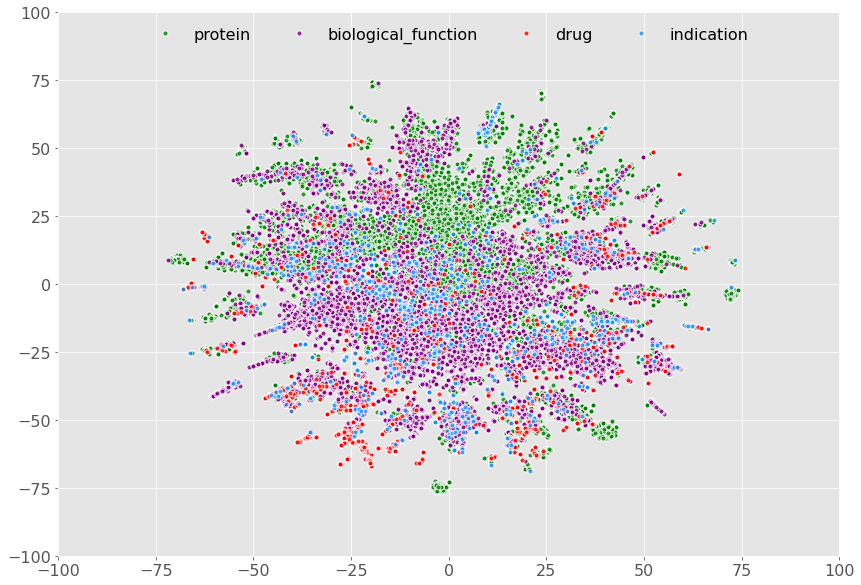

In [22]:
# t-sne plot of diffusion profiles
# reduce dimensionality of diffusion profiles for plotting
X_reduced = TruncatedSVD(n_components=50, random_state=1).fit_transform(dp_matrix)
X_embedded = TSNE(n_components=2, random_state=1, verbose=True, perplexity=50.0).fit_transform(X_reduced)

# create data frame that has decomposed diffusion profiles and the node type
label_type = [node_types[node_idx_dict[x]] for x in range(0, len(node_idx_dict.keys()))]
df = pd.DataFrame(dict(x=X_embedded[:, 0], y=X_embedded[:, 1], group=label_type))
groups = df.groupby('group')
colors = {'drug': 'red', 'indication': 'dodgerblue', 'protein': 'green', 'biological_function': 'purple'}

# create t-SNE plots
fig, ax = plt.subplots(figsize=(14, 10))
ax.margins(0.05)  # adding 5% padding to the autoscaling
for name, group in groups:
    if name == 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
for name, group in groups:
    if name != 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
ax.tick_params(labelsize=16)
ax.legend(numpoints=1, fontsize=16, frameon=False, loc="upper center", ncol=4)
plt.ylim(-100, 100)
plt.xlim(-100, 100)
plt.show()

<br>  

**Excluding Self-Importance**

In [23]:
# get metrics
min_imp_adj, max_imp_adj = dp_matrix_adj.min(1), dp_matrix_adj.max(1)
mean_imp_adj, median_imp_adj = dp_matrix_adj.mean(1), [np.median(x) for x in tqdm(dp_matrix_adj)]
# print results
print_str = 'Statistics:\n  - min={}; max={}; median={}; mean={}'
f_str = print_str.format(min(min_imp_adj), max(max_imp_adj), np.median(median_imp_adj), np.mean(mean_imp_adj))
print(f_str)

100%|██████████| 29902/29902 [00:12<00:00, 2469.95it/s]


Statistics:
  - min=2.845084216098717e-10; max=0.3117204112195686; median=4.4458779977617805e-06; mean=2.6313434941590553e-05


In [24]:
# # create histogram
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# y = sns.kdeplot(median_imp, color='#56B4E9', label='Median Importance', shade=True, linewidth=2, alpha=0.2)
# plt.title('Diffusion Profiles - Median Importance Scores (without Self-Importance)\n', fontsize=16, fontname="Arial", color='black')
# plt.suptitle('')
# plt.xlabel('Average Median Importance', fontsize=14, fontname="Arial", color='black')
# plt.ylabel('Density\n', fontsize=14, fontname="Arial", color='black')
# plt.ylim(0.0, 450000)
# plt.tick_params(labelsize=14)
# plt.yticks(color='black', fontname="Arial", fontsize=14)
# plt.xticks(color='black', fontname="Arial", fontsize=14)
# plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 29902 samples in 0.010s...
[t-SNE] Computed neighbors for 29902 samples in 18.675s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29902
[t-SNE] Computed conditional probabilities for sample 2000 / 29902
[t-SNE] Computed conditional probabilities for sample 3000 / 29902
[t-SNE] Computed conditional probabilities for sample 4000 / 29902
[t-SNE] Computed conditional probabilities for sample 5000 / 29902
[t-SNE] Computed conditional probabilities for sample 6000 / 29902
[t-SNE] Computed conditional probabilities for sample 7000 / 29902
[t-SNE] Computed conditional probabilities for sample 8000 / 29902
[t-SNE] Computed conditional probabilities for sample 9000 / 29902
[t-SNE] Computed conditional probabilities for sample 10000 / 29902
[t-SNE] Computed conditional probabilities for sample 11000 / 29902
[t-SNE] Computed conditional probabilities for sample 12000 / 29902
[t-SNE] Computed conditional probabilities for s

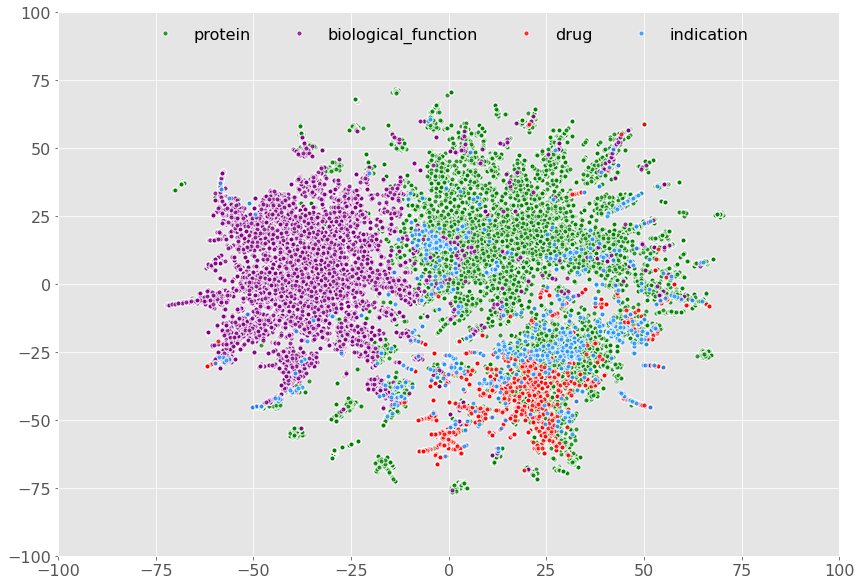

In [13]:
# t-sne plot of diffusion profiles
# reduce dimensionality of diffusion profiles for plotting
X_reduced = TruncatedSVD(n_components=50, random_state=1).fit_transform(dp_matrix_adj)
X_embedded = TSNE(n_components=2, random_state=1, verbose=True, perplexity=50.0).fit_transform(X_reduced)

# create data frame that has decomposed diffusion profiles and the node type
label_type = [node_types[node_idx_dict[x]] for x in range(0, len(node_idx_dict.keys()))]
df = pd.DataFrame(dict(x=X_embedded[:, 0], y=X_embedded[:, 1], group=label_type))
groups = df.groupby('group')
colors = {'drug': 'red', 'indication': 'dodgerblue', 'protein': 'green', 'biological_function': 'purple'}

# create t-SNE plots
fig, ax = plt.subplots(figsize=(14, 10))
ax.margins(0.05)  # adding 5% padding to the autoscaling
for name, group in groups:
    if name == 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
for name, group in groups:
    if name != 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
ax.tick_params(labelsize=16)
ax.legend(numpoints=1, fontsize=16, frameon=False, loc="upper center", ncol=4)
plt.ylim(-100, 100)
plt.xlim(-100, 100)
plt.show()

#### Examining the Impact of Self-Importance

*Randomizing values within each diffusion profile*

In [ ]:
temp_list = []
for x in tqdm(dp_matrix):
    random.shuffle(x)
    temp_list.append(list(x))
dp_matrix_rx = np.asarray(temp_list)

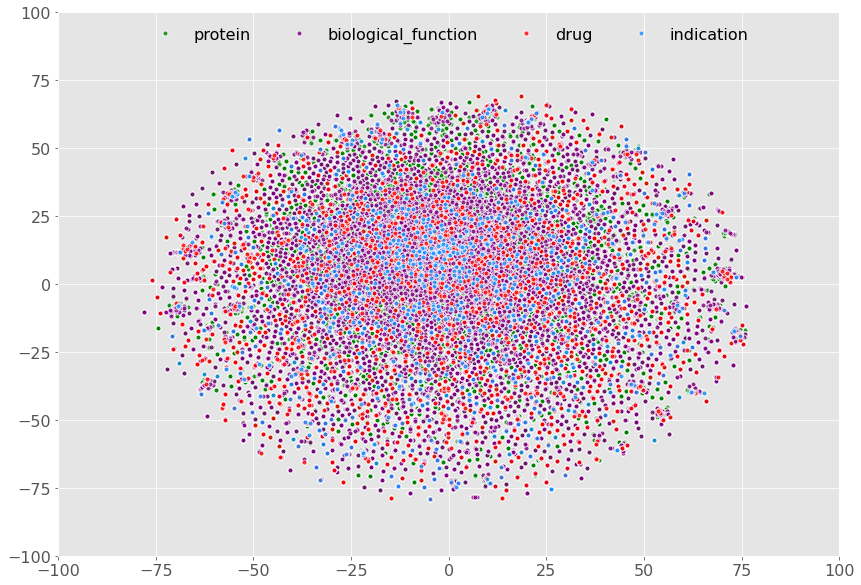

In [16]:
# t-sne plot of diffusion profiles
# reduce dimensionality of diffusion profiles for plotting
X_reduced = TruncatedSVD(n_components=50, random_state=1).fit_transform(dp_matrix_rx)
X_embedded = TSNE(n_components=2, random_state=1, verbose=True, perplexity=50.0).fit_transform(X_reduced)

# create data frame that has decomposed diffusion profiles and the node type
label_type = [node_types[node_idx_dict[x]] for x in range(0, len(node_idx_dict.keys()))]
df = pd.DataFrame(dict(x=X_embedded[:, 0], y=X_embedded[:, 1], group=label_type))
groups = df.groupby('group')
colors = {'drug': 'red', 'indication': 'dodgerblue', 'protein': 'green', 'biological_function': 'purple'}

# create t-SNE plots
fig, ax = plt.subplots(figsize=(14, 10))
ax.margins(0.05)  # adding 5% padding to the autoscaling
for name, group in groups:
    if name == 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
for name, group in groups:
    if name != 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
ax.tick_params(labelsize=16)
ax.legend(numpoints=1, fontsize=16, frameon=False, loc="upper center", ncol=4)
plt.ylim(-100, 100)
plt.xlim(-100, 100)
plt.show()

*right-shifting values within each diffusion profile*

In [6]:
temp_list = []
for x in tqdm(range(0, len(dp_matrix))):
    curr_row = list(dp_matrix[x])
    if x < len(dp_matrix) - 1:
        curr_row[x] = curr_row[x + 1]
        curr_row[x + 1] = curr_row[x]
    else:
        curr_row[x] = curr_row[0]
        curr_row[0] = curr_row[x]
    temp_list.append(curr_row)
dp_matrix_rs = np.asarray(temp_list)

100%|██████████| 29902/29902 [02:02<00:00, 243.76it/s]


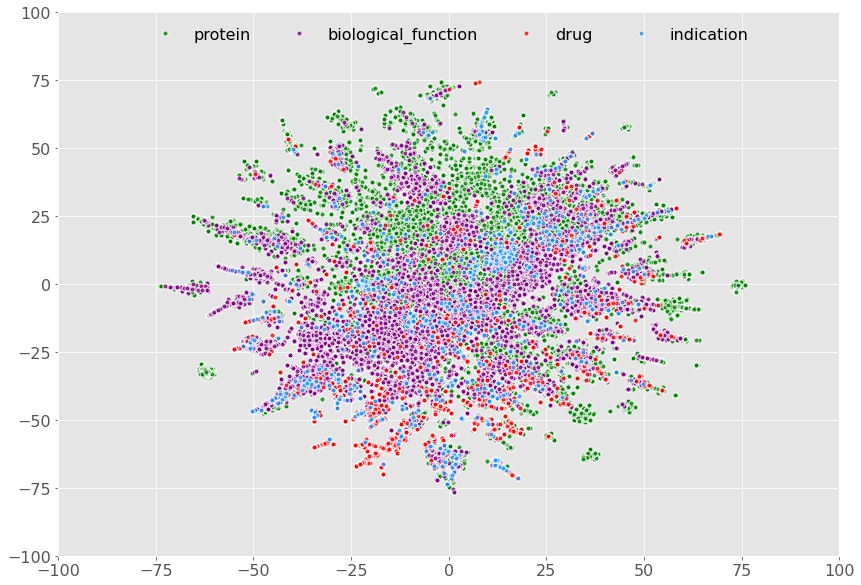

In [9]:
# t-sne plot of diffusion profiles
# reduce dimensionality of diffusion profiles for plotting
X_reduced = TruncatedSVD(n_components=50, random_state=1).fit_transform(dp_matrix_rs)
X_embedded = TSNE(n_components=2, random_state=1, verbose=True, perplexity=50.0).fit_transform(X_reduced)

# create data frame that has decomposed diffusion profiles and the node type
label_type = [node_types[node_idx_dict[x]] for x in range(0, len(node_idx_dict.keys()))]
df = pd.DataFrame(dict(x=X_embedded[:, 0], y=X_embedded[:, 1], group=label_type))
groups = df.groupby('group')
colors = {'drug': 'red', 'indication': 'dodgerblue', 'protein': 'green', 'biological_function': 'purple'}

# create t-SNE plots
fig, ax = plt.subplots(figsize=(14, 10))
ax.margins(0.05)  # adding 5% padding to the autoscaling
for name, group in groups:
    if name == 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
for name, group in groups:
    if name != 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
ax.tick_params(labelsize=16)
ax.legend(numpoints=1, fontsize=16, frameon=False, loc="upper center", ncol=4)
plt.ylim(-100, 100)
plt.xlim(-100, 100)
plt.show()

*Setting self-importance to a large constant*

In [23]:
temp_list = []
for node in tqdm(node_idx_dict.keys()):
    node_matrix = list(dp_matrix[node])
    node_matrix[node] = 1.0
    temp_list.append(node_matrix)
dp_matrix_cv = np.asarray(temp_list)


100%|██████████| 29902/29902 [05:14<00:00, 95.13it/s]  


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 29902 samples in 0.025s...
[t-SNE] Computed neighbors for 29902 samples in 18.895s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29902
[t-SNE] Computed conditional probabilities for sample 2000 / 29902
[t-SNE] Computed conditional probabilities for sample 3000 / 29902
[t-SNE] Computed conditional probabilities for sample 4000 / 29902
[t-SNE] Computed conditional probabilities for sample 5000 / 29902
[t-SNE] Computed conditional probabilities for sample 6000 / 29902
[t-SNE] Computed conditional probabilities for sample 7000 / 29902
[t-SNE] Computed conditional probabilities for sample 8000 / 29902
[t-SNE] Computed conditional probabilities for sample 9000 / 29902
[t-SNE] Computed conditional probabilities for sample 10000 / 29902
[t-SNE] Computed conditional probabilities for sample 11000 / 29902
[t-SNE] Computed conditional probabilities for sample 12000 / 29902
[t-SNE] Computed conditional probabilities for s

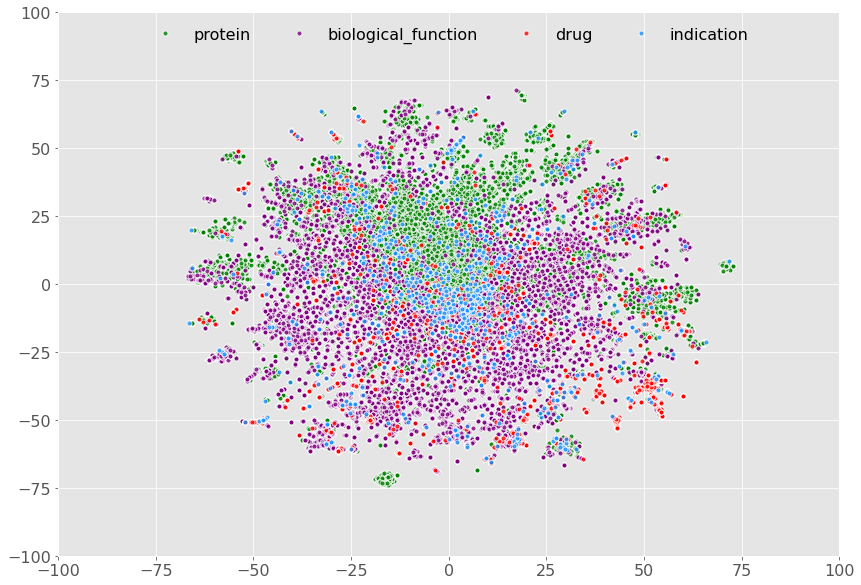

In [24]:
# t-sne plot of diffusion profiles
# reduce dimensionality of diffusion profiles for plotting
X_reduced = TruncatedSVD(n_components=50, random_state=1).fit_transform(dp_matrix_cv)
X_embedded = TSNE(n_components=2, random_state=1, verbose=True, perplexity=50.0).fit_transform(X_reduced)

# create data frame that has decomposed diffusion profiles and the node type
label_type = [node_types[node_idx_dict[x]] for x in range(0, len(node_idx_dict.keys()))]
df = pd.DataFrame(dict(x=X_embedded[:, 0], y=X_embedded[:, 1], group=label_type))
groups = df.groupby('group')
colors = {'drug': 'red', 'indication': 'dodgerblue', 'protein': 'green', 'biological_function': 'purple'}

# create t-SNE plots
fig, ax = plt.subplots(figsize=(14, 10))
ax.margins(0.05)  # adding 5% padding to the autoscaling
for name, group in groups:
    if name == 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
for name, group in groups:
    if name != 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
ax.tick_params(labelsize=16)
ax.legend(numpoints=1, fontsize=16, frameon=False, loc="upper center", ncol=4)
plt.ylim(-100, 100)
plt.xlim(-100, 100)
plt.show()

*Setting self-importance to a small constant*

In [25]:
temp_list = []
for node in tqdm(node_idx_dict.keys()):
    node_matrix = list(dp_matrix[node])
    node_matrix[node] = 0.0
    temp_list.append(node_matrix)
dp_matrix_cv2 = np.asarray(temp_list)


100%|██████████| 29902/29902 [03:20<00:00, 148.87it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 29902 samples in 0.012s...
[t-SNE] Computed neighbors for 29902 samples in 19.810s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29902
[t-SNE] Computed conditional probabilities for sample 2000 / 29902
[t-SNE] Computed conditional probabilities for sample 3000 / 29902
[t-SNE] Computed conditional probabilities for sample 4000 / 29902
[t-SNE] Computed conditional probabilities for sample 5000 / 29902
[t-SNE] Computed conditional probabilities for sample 6000 / 29902
[t-SNE] Computed conditional probabilities for sample 7000 / 29902
[t-SNE] Computed conditional probabilities for sample 8000 / 29902
[t-SNE] Computed conditional probabilities for sample 9000 / 29902
[t-SNE] Computed conditional probabilities for sample 10000 / 29902
[t-SNE] Computed conditional probabilities for sample 11000 / 29902
[t-SNE] Computed conditional probabilities for sample 12000 / 29902
[t-SNE] Computed conditional probabilities for s

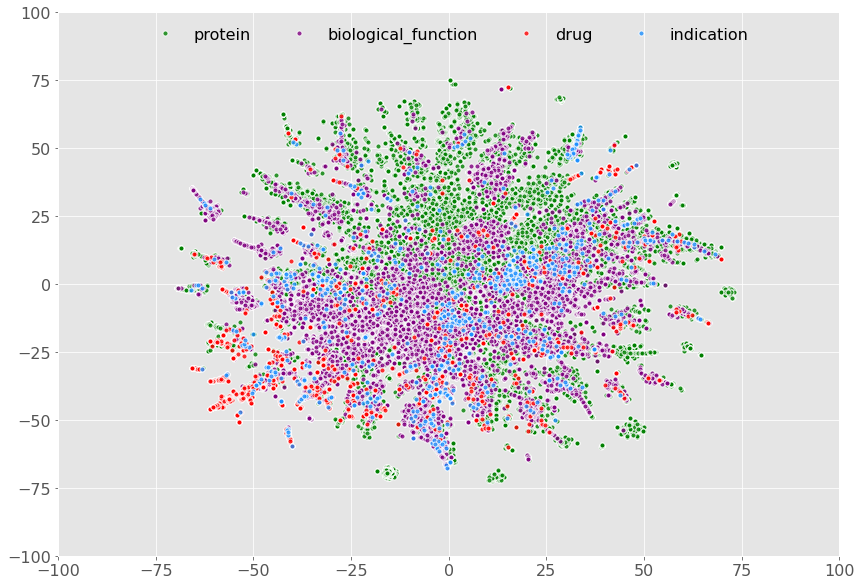

In [26]:
# t-sne plot of diffusion profiles
# reduce dimensionality of diffusion profiles for plotting
X_reduced = TruncatedSVD(n_components=50, random_state=1).fit_transform(dp_matrix_cv2)
X_embedded = TSNE(n_components=2, random_state=1, verbose=True, perplexity=50.0).fit_transform(X_reduced)

# create data frame that has decomposed diffusion profiles and the node type
label_type = [node_types[node_idx_dict[x]] for x in range(0, len(node_idx_dict.keys()))]
df = pd.DataFrame(dict(x=X_embedded[:, 0], y=X_embedded[:, 1], group=label_type))
groups = df.groupby('group')
colors = {'drug': 'red', 'indication': 'dodgerblue', 'protein': 'green', 'biological_function': 'purple'}

# create t-SNE plots
fig, ax = plt.subplots(figsize=(14, 10))
ax.margins(0.05)  # adding 5% padding to the autoscaling
for name, group in groups:
    if name == 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
for name, group in groups:
    if name != 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
ax.tick_params(labelsize=16)
ax.legend(numpoints=1, fontsize=16, frameon=False, loc="upper center", ncol=4)
plt.ylim(-100, 100)
plt.xlim(-100, 100)
plt.show()

*Examining Self-Importance Values*  
The goal of this section is to examine self-importance values in hopes of trying to determine what they mean. Traditionally, PageRank does not provide a measure of a website's self-importance. We want to understand if that value is related to node type (e.g., do all protein nodes have a similar self-importance score?) and what it means compared to the other values within the diffusion profile.

In [24]:
# get the diffusion profile for lisinopril
dp_imp_lis = dp_matrix[lisinopril_index]

# get the min, median, and max values for this diffusion profile
lis_dp_min = min(dp_imp_lis)
lis_dp_med = np.median(dp_imp_lis)
lis_dp_max = max(dp_imp_lis)

# get lisinopril's self-importance
lis_dp_self = dp_imp_lis[lisinopril_index]

# print results
str1 = "Lisinopril Importance:\n  -min: {}\n  -median:{}\n  -max: {}\n  -self-importance: {}"
print(str1.format(lis_dp_min, lis_dp_med, lis_dp_max, lis_dp_self))

Lisinopril Importance:
  -min: 9.553581263687694e-10
  -median:3.5284276195374334e-06
  -max:0.22657256483999866
  -self-importance: 0.22657256483999866


In [6]:
# loop over all matrices and check if the max value is equal to that node's self-importance
node_index = []
for x in tqdm(range(0, len(dp_matrix))):
    dp = dp_matrix[x]
    self_imp = dp[x]
    max_imp = max(dp)
    if self_imp != max_imp:
        node_index.append(x)

100%|██████████| 29902/29902 [01:11<00:00, 418.55it/s]


In [20]:
# examine the nodes who's max DP value is not equal to their self importance
for x in node_index:
    node_id = node_idx_dict[x]
    node_label = node_labels[node_id]
    node_type = node_types[node_id]
    # diffusion profile information
    dp = dp_matrix[x]
    self_imp = dp[x]
    max_imp = max(dp)
    imp_diff = max_imp - self_imp
    # graph information (min=2; max=4600; median=18.0; mean=64.012)
    x_deg = msi_graph.degree[node_id]
    nodes_o = list(msi_graph.neighbors(node_id))
    out_neighbors = ', '.join([node_labels[n] for n in nodes_o])
    # print information
    str2 = '{} ({}; {})\n   - self-importance: {}\n   - max: {}\n   - difference: {}\n   - degree: {}\n   - neighborhood:{}'
    print(str2.format(node_label, node_type, node_id, self_imp, max_imp, imp_diff, x_deg, out_neighbors))

streptomycin (drug; DB01082)
   - self-importance: 0.22779529583579042
   - max: 0.2437421820405348
   - difference: 0.01594688620474438
   - degree: 2
   - neighborhood:PADI4
armodafinil (drug; DB06413)
   - self-importance: 0.2311527690643199
   - max: 0.23439832432610247
   - difference: 0.003245555261782579
   - degree: 2
   - neighborhood:SLC6A3
levocarnitine-propionate (drug; levocarnitine-propionate)
   - self-importance: 0.19678168855416003
   - max: 0.19695875066459415
   - difference: 0.0001770621104341119
   - degree: 2
   - neighborhood:CRAT
Abortion, Habitual (indication; C0000809)
   - self-importance: 0.1706742712733416
   - max: 0.2172496601659133
   - difference: 0.046575388892571706
   - degree: 2
   - neighborhood:SYCP3
Mucopolysaccharidosis Vi (indication; C0026709)
   - self-importance: 0.1999636824713504
   - max: 0.20592264829065016
   - difference: 0.00595896581929975
   - degree: 2
   - neighborhood:ARSB
Renal Carnitine Transport Defect (indication; C0342788)
 

<br>

**Case Study: Lisinopril vs Cough**

In [26]:
# get each node's diffusion profile
dp_imp_lis = dp_matrix[lisinopril_index]
dp_imp_cough = dp_matrix[cough_index]

In [27]:
# get the range of importance values for lisinopril
gets_simple_statistics(dp_imp_lis, "Diffusion Profile", "Lisinopril")

Statistics (Diffusion Profile, Lisinopril):
  - min=9.553581263687694e-10; max=0.22657256483999866; median=3.5284276195374334e-06; mean=3.3442579091699556e-05


In [28]:
# get the range of importance values for coughing
gets_simple_statistics(dp_imp_cough, "Diffusion Profile", "Cough")

Statistics (Diffusion Profile, Cough):
  - min=1.5920649802069863e-09; max=0.21280998016599456; median=5.563051926186945e-06; mean=3.344257909169957e-05


*Diffusion Profile Importance Rank*  
Retrieve the importance of each node within the other node's diffusion profile. Return this information along with the relative rank and list of diseases ranked more important.  

In [29]:
# get the 
imp = get_node_pair_importance(dp_matrix, lisinopril_index, cough_index, 'lisinopril', 'coughing')
print('\n'.join(imp))

The importance of coughing within lisinopril's Diffusion Profile: 0.0005531529238047234
The importance of lisinopril within coughing's Diffusion Profile: 8.393128122828203e-05
  - The minimum importance of both node's Diffusion Profiles: 8.393128122828203e-05
  - The maximum importance of both node's Diffusion Profiles: 0.0005531529238047234
  - The average importance of both node's Diffusion Profiles: 0.0003185421025165027


Cough Rank

In [30]:
# get the rank of "cough" in lisinopril's diffusion profile
lis_imp_dict = {dp_imp_lis[x]: x for x in node_idx_dict.keys()}
rank_dict = OrderedDict(sorted(lis_imp_dict.items(), reverse=True))
cough_score = [(k, v) for k, v in lis_imp_dict.items() if v == cough_index]
cough_rank = list(rank_dict.items()).index(cough_score[0])
# print results
str_print = "{} had a position of {} with score {} in Lisinopril's sorted list of similar nodes"
print(str_print.format('Cough', str(cough_rank), str(round(cough_score[0][0], 5))))

Cough had a position of 121 with score 0.00055 in Lisinopril's sorted list of similar nodes


In [31]:
# get and print items ranked higher than cough
higher_ranked_ents = list(rank_dict.items())[0:cough_rank]
res = ['{} ({})'.format(node_labels[node_idx_dict[x[1]]], str(round(x[0], 5))) for x in higher_ranked_ents]
print('\n'.join(res))

lisinopril (0.22657)
ACE2 (0.10847)
ACE (0.10444)
Spontaneous Abortion (0.02044)
regulation of systemic arterial blood pressure by renin-angiotensin (0.0121)
moexipril (0.01019)
angiotensin-mediated drinking behavior (0.00751)
positive regulation of gap junction assembly (0.00706)
receptor-mediated virion attachment to host cell (0.0069)
regulation of cardiac conduction (0.00675)
receptor biosynthetic process (0.00655)
arachidonic acid secretion (0.00632)
kidney development (0.00555)
peptide catabolic process (0.00531)
amyloid-beta metabolic process (0.00522)
hormone catabolic process (0.0051)
AGT (0.00498)
regulation of angiotensin metabolic process (0.00483)
AGXT (0.00424)
regulation of systemic arterial blood pressure by hormone (0.00394)
BDKRB2 (0.00239)
ENPEP (0.00237)
HNF1B (0.00236)
virion attachment to host cell (0.0022)
CALM1 (0.00216)
GHRL (0.00215)
CALM2 (0.00214)
ACTB (0.00212)
CALM3 (0.00212)
COMT (0.00212)
drinking behavior (0.00209)
LMNA (0.00209)
EWSR1 (0.00208)
HRAS (0

Lisinopril Rank

In [32]:
# get the rank of "cough" in lisinopril's diffusion profile
cough_imp_dict = {dp_imp_cough[x]: x for x in node_idx_dict.keys()}
rank_dict = OrderedDict(sorted(cough_imp_dict.items(), reverse=True))
lis_score = [(k, v) for k, v in cough_imp_dict.items() if v == lisinopril_index]
lis_rank = list(rank_dict.items()).index(lis_score[0])
# print results
str_print = "{} had a position of {} with score {} in Cough's sorted list of similar nodes"
print(str_print.format('Lisinopril', str(lis_rank), str(round(lis_score[0][0], 5))))

Lisinopril had a position of 1143 with score 8e-05 in Cough's sorted list of similar nodes


In [33]:
# get and print items ranked higher than cough
higher_ranked_ents = list(rank_dict.items())[0:lis_rank]
res = ['{} ({})'.format(node_labels[node_idx_dict[x[1]]], str(round(x[0], 5))) for x in higher_ranked_ents]
print('\n'.join(res))

Coughing (0.21281)
HLA-DRB1 (0.00909)
IGHM (0.00868)
ACE (0.00835)
STAT3 (0.00834)
GBA (0.0083)
TCF3 (0.00829)
MARS (0.00825)
TSC1 (0.00824)
PTPN22 (0.00823)
PIK3R1 (0.00823)
PRTN3 (0.0082)
HLA-DPB1 (0.00817)
CTLA4 (0.00813)
TSC2 (0.00811)
CD79A (0.00808)
RNF6 (0.00808)
KNG1 (0.00805)
IGLL1 (0.00802)
TGFBR2 (0.00802)
CD79B (0.00799)
WWOX (0.00799)
BLNK (0.00798)
DLEC1 (0.00787)
polysaccharide assembly with MHC class II protein complex (0.00434)
EIF4B (0.00416)
protein homooligomerization (0.00398)
protein homotetramerization (0.00388)
intracellular signal transduction (0.00376)
zinc (0.00324)
positive regulation of transcription by RNA polymerase II (0.00269)
positive regulation of transcription, DNA-templated (0.00256)
fostamatinib (0.00208)
Major Depressive Disorder (0.00198)
cellular response to transforming growth factor beta stimulus (0.00178)
negative regulation of Wnt signaling pathway (0.00176)
schizophrenia (0.00173)
Nausea and vomiting (0.00165)
squamous cell carcinoma (0.001

*Determining Rank of Known Negative Controls and Side Effects*  
This section examines the rank of known negative controls and side effects according to their importance values.

Known Negative Controls

In [58]:
neg_cont_dict = importance_rank_lookup(dp_imp_lis, node_idx_dict, known_negative_controls)

# print results ordered by rank (smallest to largest)
sorted_keys = sorted(list(neg_cont_dict.keys()))
for k in sorted_keys:
    rank = k; code, score = neg_cont_dict[k]
    str_print = "RANK: {}; {} ({}); score: {}"
    print(str_print.format(str(rank), node_labels[code], code, str(score)))

RANK: 175; Skin Neoplasms (C0037286); score: 0.00038430700797186646
RANK: 303; endometriosis (C0014175); score: 0.00018540678088855393
RANK: 351; Colorectal Neoplasms (C0009404); score: 0.00015304794652144427
RANK: 1167; Dermatologic disorders (C0037274); score: 4.8427006276092096e-05
RANK: 1193; contact dermatitis (C0011616); score: 4.7661898931592165e-05
RANK: 1335; Disorder of eye (C0015397); score: 4.3207183005232e-05
RANK: 1472; Crohn's disease (C0010346); score: 3.983095790493626e-05
RANK: 1732; gastroesophageal reflux disease (GERD) (C0017168); score: 3.470459036145109e-05
RANK: 1899; Hyperkeratosis (C0870082); score: 3.236054103175073e-05
RANK: 4057; keratosis (C0022593); score: 1.6500269455674473e-05
RANK: 4797; Arthritis (C0003864); score: 1.4187731267240151e-05
RANK: 7236; macular degeneration (C0024437); score: 9.334178067508834e-06
RANK: 8895; Thrombophilia (C0398623); score: 7.39779054781024e-06
RANK: 9061; dry eye syndrome (C0013238); score: 7.227510321796957e-06
RANK: 1

Known Side Effects

In [57]:
knwn_se_dict = importance_rank_lookup(dp_imp_lis, node_idx_dict, known_side_effects)

# print results ordered by rank (smallest to largest)
sorted_keys = sorted(list(knwn_se_dict.keys()))
for k in sorted_keys:
    rank = k; code, score = knwn_se_dict[k]
    str_print = "RANK: {}; {} ({}); score: {}"
    print(str_print.format(str(rank), node_labels[code], code, str(score)))

RANK: 84; Renal Insufficiency (C1565489); score: 0.0007303146274393398
RANK: 113; Drug Allergy (C0013182); score: 0.0005710401429895159
RANK: 196; vertigo (C0042571); score: 0.0003107716035671973
RANK: 406; Kidney Failure (C0035078); score: 0.00012989044791077354
RANK: 679; hypotension (C0020649); score: 7.815441823313034e-05
RANK: 944; fever (C0015967); score: 5.787570387922413e-05
RANK: 1264; nephrotic syndrome (C0027726); score: 4.5078566871073876e-05
RANK: 1391; muscle pain (C0231528); score: 4.176808548154564e-05
RANK: 1420; edema (C0013604); score: 4.1011455255912223e-05
RANK: 1492; vomiting (C0042963); score: 3.925135233570592e-05
RANK: 1750; heartburn (C0018834); score: 3.4414889820072605e-05
RANK: 2022; Dyspnea (C0013404); score: 3.0562277220883066e-05
RANK: 3346; pancreatitis (C0030305); score: 1.9419797554363164e-05
RANK: 3700; Hyperkalemia (C0020461); score: 1.788142208419278e-05
RANK: 5412; headache (C0018681); score: 1.2651628398980005e-05
RANK: 6607; Rhinitis (C0035455);

<br>

### Cosine Similarity  <a class="anchor" id="cosine-similarity"></a>
***
This section examines the utility of diffusion profile cosine similarity. Two different approaches or tasks will be examined. The first task will examine the cosine similarity of one node with respect to all other nodes in the graph. The second task will examine the overlap between two node's sets of most similar entities employing different ranking strategies. Additional details provided below.

* [Task 1](#task1)  
* [Task 2](#task2)  

<br>

***Including Self-Importance***

In [59]:
# all pairwise cosine similarity scores (takes ~40 min)
cosine_sim = cosine_similarity(dp_matrix, dp_matrix).flatten()
gets_simple_statistics(cosine_sim, "dp_matrix", "cosine similarity")

Statistics (dp_matrix, cosine similarity):
  - min=4.530673582887852e-05; max=1.0000000000000295; median=0.0019678661253525096; mean=0.002794446127531196


***Excluding Self-Importance***

In [60]:
# all pairwise cosine similarity scores (takes ~40 min)
cosine_sim_adj = cosine_similarity(dp_matrix_adj, dp_matrix_adj).flatten()
gets_simple_statistics(cosine_sim_adj, "dp_matrix_adj", "cosine similarity")

Statistics (dp_matrix_adj, cosine similarity):
  - min=6.301928269802017e-05; max=1.0000000000000282; median=0.009749410691090594; mean=0.019147605207935563


<br>

### Task 1  <a class="anchor" id="task1"></a>
This task will examine the following three ways to obtain the cosine similarity score between **lisinopril** and **cough**:
  - Get cosine similarity score for $node_i$ and $node_j$
  - Cosine Similarity Rank
    - $node_i$ ranking within $node_j$’s sorted list of similar nodes
    - $node_j$ ranking within $node_i$’s sorted list of similar nodes

Extract each node's diffusion profile from matrix with and without self-importance

In [30]:
# including self-importance
dp_imp_lisinopril = dp_matrix[lisinopril_index]
dp_imp_cough = dp_matrix[cough_index]

In [37]:
# excluding self-importance
dp_imp_lisinopril_adj = dp_matrix_adj[lisinopril_index]
dp_imp_cough_adj = dp_matrix_adj[cough_index]

<br>

***Including Self-Importance***

In [27]:
co_sin = round(dot(dp_imp_lisinopril, dp_imp_cough)/(norm(dp_imp_lisinopril) * norm(dp_imp_cough)), 10)
print('The Cosine Similarity between {} and {} is: {}'.format('lisinopril', 'cough', co_sin))

The Cosine Similarity between lisinopril and cough is: 0.0186984424


In [31]:
# calculate after randomizing the order of entries within each dp (just a test)
dp_imp_lisinopril_r = dp_imp_lisinopril.copy()
random.shuffle(dp_imp_lisinopril_r)
dp_imp_cough_r = dp_imp_cough.copy()
random.shuffle(dp_imp_cough_r)
co_sin_r = round(dot(dp_imp_lisinopril_r, dp_imp_cough_r)/(norm(dp_imp_lisinopril_r) * norm(dp_imp_cough_r)), 10)
print('The Cosine Similarity between {} and {} is: {}'.format('lisinopril', 'cough', co_sin_r))

The Cosine Similarity between lisinopril and cough is: 0.0004818141


In [29]:
dp_imp_cough_r

*Cough Rank*

In [39]:
# get the ranking of cough within lisinopril's sorted list of similar nodes
# get lisinoprils's cosine similarity
sim_res_lis = similarity_search(dp_matrix, lisinopril_index, len(node_idx_dict) - 1)

# get ranking information
cough_in_lis = [x for x in sim_res_lis if x[0] == cough_index]
cough_in_lis_position = sim_res_lis.index(cough_in_lis[0])
cough_in_lis_score = cough_in_lis[0][1]
str_print = "{} had a position of {} with score {} in Lisinopril's sorted list of similar nodes"
print(str_print.format('Cough', str(cough_in_lis_position), str(round(cough_in_lis_score, 5))))

Cough had a position of 73 with score 0.0187 in Lisinopril's sorted list of similar nodes


In [40]:
# get and print items ranked higher than cough
higher_ranked_ents = sim_res_lis[0:cough_in_lis_position]
res = ['{} ({})'.format(node_labels[node_idx_dict[x[0]]], str(round(x[1], 5))) for x in higher_ranked_ents]
print('\n'.join(res))

ACE2 (0.47657)
ACE (0.40068)
moexipril (0.37872)
temocapril (0.2745)
cilazapril (0.2745)
quinaprilat (0.2745)
imidapril (0.2745)
quinapril (0.2745)
Spirapril (0.2745)
trandolapril (0.2745)
fosinopril (0.2745)
benazepril (0.2745)
enalapril (0.2745)
angiotensin-mediated drinking behavior (0.27003)
regulation of angiotensin metabolic process (0.21756)
regulation of systemic arterial blood pressure by renin-angiotensin (0.20898)
positive regulation of gap junction assembly (0.16914)
drinking behavior (0.16318)
deserpidine (0.16008)
perindopril (0.15884)
enalaprilat (0.15858)
ramipril (0.15858)
regulation of gap junction assembly (0.09957)
receptor-mediated virion attachment to host cell (0.09774)
hormone catabolic process (0.08935)
coronary artery restenosis (0.08716)
Staphylococcal Infections (0.08682)
Gaucher disease (0.0857)
receptor biosynthetic process (0.0837)
Spontaneous Abortion (0.0795)
captopril (0.07439)
regulation of cardiac conduction (0.07289)
DLEU2 (0.06631)
arachidonic acid

*Lisinopril Rank*

In [41]:
# get the ranking of lisinopril within cough's sorted list of similar nodes
# get cough's cosine similarity
sim_res_cough = similarity_search(dp_matrix, cough_index, len(node_idx_dict) - 1)

# get ranking information
lis_in_cough = [x for x in sim_res_cough if x[0] == lisinopril_index]
lis_in_cough_position = sim_res_cough.index(lis_in_cough[0])
lis_in_cough_score = lis_in_cough[0][1]
str_print = "{} had a position of {} with score {} in Cough's sorted list of similar nodes"
print(str_print.format('Lisinopril', str(lis_in_cough_position), str(round(lis_in_cough_score, 5))))

Lisinopril had a position of 77 with score 0.0187 in Cough's sorted list of similar nodes


In [42]:
# get and print items ranked higher than cough
higher_ranked_ents = sim_res_cough[0:lis_in_cough_position]
res = ['{} ({})'.format(node_labels[node_idx_dict[x[0]]], str(round(x[1], 5))) for x in higher_ranked_ents]
print('\n'.join(res))

DLEC1 (0.10953)
RNF6 (0.09223)
MARS (0.08126)
IGLL1 (0.07212)
CD79A (0.06143)
TCF3 (0.06042)
BLNK (0.05968)
CD79B (0.05935)
KNG1 (0.05926)
IGHM (0.05699)
PRTN3 (0.05352)
WWOX (0.05326)
HLA-DRB1 (0.05222)
PIK3R1 (0.05155)
TSC1 (0.05048)
TSC2 (0.05021)
HLA-DPB1 (0.0488)
PTPN22 (0.04757)
STAT3 (0.04682)
CTLA4 (0.04661)
TGFBR2 (0.04617)
GBA (0.04567)
ACE (0.04542)
CLEC17A (0.04108)
Tuberous Sclerosis (0.03891)
subependymal giant cell astrocytoma (SEGA) (0.03891)
OR5H6 (0.03846)
velaglucerase alfa (0.03596)
RPS15AP21 (0.03589)
MYH16 (0.03589)
Niclosamide (0.03411)
polysaccharide assembly with MHC class II protein complex (0.03379)
immunoglobulin V(D)J recombination (0.03294)
Giant Cell Arteritis (0.03203)
temocapril (0.03117)
cilazapril (0.03117)
quinaprilat (0.03117)
imidapril (0.03117)
quinapril (0.03117)
Spirapril (0.03117)
trandolapril (0.03117)
fosinopril (0.03117)
enalapril (0.03117)
benazepril (0.03117)
VPREB3 (0.02921)
renal angiomyolipoma (0.02825)
Osteomyelitis (0.0282)
Infection 

<br>

***Excluding Self-Importance***

In [43]:
co_sin = round(dot(dp_imp_lisinopril_adj, dp_imp_cough_adj)/(norm(dp_imp_lisinopril_adj) * norm(dp_imp_cough_adj)), 10)
print('The Cosine Similarity between {} and {} is: {}'.format('lisinopril', 'cough', co_sin))

The Cosine Similarity between lisinopril and cough is: 0.1477960718


*Cough Rank*

In [44]:
# get the ranking of cough within lisinopril's sorted list of similar nodes
# get lisinoprils's cosine similarity
sim_res_lis_adj = similarity_search(dp_matrix_adj, lisinopril_index, len(node_idx_dict) - 1)

# get ranking information
cough_in_lis = [x for x in sim_res_lis_adj if x[0] == cough_index]
cough_in_lis_position = sim_res_lis_adj.index(cough_in_lis[0])
cough_in_lis_score = cough_in_lis[0][1]
str_print = "{} had a position of {} with score {} in Lisinopril's sorted list of similar nodes"
print(str_print.format('Cough', str(cough_in_lis_position), str(round(cough_in_lis_score, 5))))

Cough had a position of 39 with score 0.1478 in Lisinopril's sorted list of similar nodes


In [45]:
# get and print items ranked higher than cough
higher_ranked_ents = sim_res_lis_adj[0:cough_in_lis_position]
res = ['{} ({})'.format(node_labels[node_idx_dict[x[0]]], str(round(x[1], 5))) for x in higher_ranked_ents]
print('\n'.join(res))

quinapril (0.69495)
Spirapril (0.69478)
cilazapril (0.69478)
temocapril (0.69406)
imidapril (0.69394)
quinaprilat (0.6936)
enalapril (0.68797)
benazepril (0.68791)
trandolapril (0.68785)
fosinopril (0.6878)
angiotensin-mediated drinking behavior (0.63581)
regulation of angiotensin metabolic process (0.60867)
regulation of systemic arterial blood pressure by renin-angiotensin (0.58647)
moexipril (0.55205)
deserpidine (0.50584)
perindopril (0.49619)
enalaprilat (0.4928)
positive regulation of gap junction assembly (0.47205)
Staphylococcal Infections (0.3495)
coronary artery restenosis (0.34431)
drinking behavior (0.34231)
hormone catabolic process (0.32443)
captopril (0.32166)
Gaucher disease (0.31738)
receptor biosynthetic process (0.26394)
receptor-mediated virion attachment to host cell (0.25165)
regulation of cardiac conduction (0.23598)
ACE2 (0.23151)
Berylliosis (0.22878)
regulation of gap junction assembly (0.22769)
peptide catabolic process (0.21406)
DLEU2 (0.20664)
Chronic schiz

*Lisinopril Rank*

In [46]:
# get the ranking of lisinopril within cough's sorted list of similar nodes
# get cough's cosine similarity
sim_res_cough_adj = similarity_search(dp_matrix_adj, cough_index, len(node_idx_dict) - 1)

# get ranking information
lis_in_cough = [x for x in sim_res_cough_adj if x[0] == lisinopril_index]
lis_in_cough_position = sim_res_cough_adj.index(lis_in_cough[0])
lis_in_cough_score = lis_in_cough[0][1]
str_print = "{} had a position of {} with score {} in Cough's sorted list of similar nodes"
print(str_print.format('Lisinopril', str(lis_in_cough_position), str(round(lis_in_cough_score, 5))))

Lisinopril had a position of 114 with score 0.1478 in Cough's sorted list of similar nodes


In [47]:
# get and print items ranked higher than cough
higher_ranked_ents = sim_res_cough_adj[0:lis_in_cough_position]
res = ['{} ({})'.format(node_labels[node_idx_dict[x[0]]], str(round(x[1], 5))) for x in higher_ranked_ents]
print('\n'.join(res))

Exanthema (0.48094)
Osteomyelitis (0.39287)
sinusitis (0.39048)
Infection of bone (0.38539)
fever (0.33135)
Arthritis (0.32207)
conjunctivitis (0.31461)
fatigue (0.30359)
Tuberous Sclerosis (0.29262)
subependymal giant cell astrocytoma (SEGA) (0.29247)
Nausea and vomiting (0.2662)
Immunologic Deficiency Syndromes (0.25961)
Berylliosis (0.25876)
diarrhea (0.25277)
renal angiomyolipoma (0.2472)
Autoimmune Diseases (0.24405)
squamous cell carcinoma (0.24236)
abdominal pain (0.2398)
OR5H6 (0.22648)
Brain Ischemia (0.22065)
CLEC17A (0.21882)
Vasculitis (0.21761)
YWHAA (0.21255)
Dyspnea (0.21201)
Sarcoidosis (0.21083)
Niclosamide (0.21079)
Infectious Disease Of Lung (0.2105)
quinaprilat (0.20899)
imidapril (0.20855)
temocapril (0.20849)
cilazapril (0.20801)
Spirapril (0.20801)
quinapril (0.20793)
enalapril (0.20776)
benazepril (0.20775)
trandolapril (0.20774)
fosinopril (0.20772)
RPS15AP21 (0.20543)
MYH16 (0.20543)
joint pain (0.20523)
Giant Cell Arteritis (0.20404)
VPREB1 (0.20255)
Pulmonar

<br>

### Task 2  <a class="anchor" id="task2"></a>
This task will examine the following two ways to obtain cosine similarity score between **lisinopril** and **cough** with a specific focus on the overlap between the two node's profiles:
  - Overlap between sorted list of $node_i$ and $node_j$’s similarity scores to all other nodes in graph
      - Get top-1000 most similar nodes to each node, apply metric, sort descending and return top $N$ hits
      - Apply geometric mean to scores for same entities in each node’s list, sort, and return top $N$ hits 

<br>

***Including Self-Importance***

In [48]:
# get top-1000 most similar nodes for lisinopril and cough
top_hits = 1000
lis_top_1000_sim = sim_res_lis[0:top_hits + 1]
cough_top_1000_sim = sim_res_cough[0:top_hits + 1]

**Strategy 1:** Get top-1000 most similar nodes to each node, apply metric, sort descending and return top $N$ hits

In [49]:
# create a Pandas DataFrame that contains the overlapping results
df_sim_overlap = get_overlapping_concepts(
    lis_top_1000_sim, cough_top_1000_sim,
    node_idx_dict, node_types, node_labels, "lisinopril", "cough")

# write data drame
df_sim_overlap.to_csv('experiment1_similarity_overlap_selfimp_top1000.tsv', sep='\t', index=False, header=True)

In [50]:
# sort by score
var = 'geometric_mean_score'
df_sim_overlap.sort_values(by=var, ascending=False, inplace=True)
df_sim_overlap.head(n=25)

,concept_name,concept_id,concept_type,lisinopril_org_score,cough_org_score,min_score,max_score,mean_score,median_score,geometric_mean_score
135,ACE,1636,protein,0.400681,0.045418,0.045418,0.400681,0.223049,0.223049,0.134900
162,temocapril,DB08836,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
140,cilazapril,DB01340,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
3,quinaprilat,quinaprilat,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
76,imidapril,DB11783,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
149,quinapril,DB00881,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
139,Spirapril,DB01348,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
174,trandolapril,DB00519,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
156,fosinopril,DB00492,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
180,benazepril,DB00542,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499


<br>

**Strategy 2:** Apply geometric mean to scores for same entities in each node’s list, sort, and return top $N$ hits 

In [51]:
# create a Pandas DataFrame that contains the overlapping results
df_sim_overlap2 = get_overlapping_concepts(
    sim_res_lis, sim_res_cough,
    node_idx_dict, node_types, node_labels, "lisinopril", "cough")

# write data drame
df_sim_overlap2.to_csv('experiment1_similarity_overlap_selfimp_all.tsv', sep='\t', index=False, header=True)

In [52]:
# sort by score
var = 'geometric_mean_score'
df_sim_overlap2.sort_values(by=var, ascending=False, inplace=True)
df_sim_overlap2.head(n=25)

,concept_name,concept_id,concept_type,lisinopril_org_score,cough_org_score,min_score,max_score,mean_score,median_score,geometric_mean_score
890,ACE,1636,protein,0.400681,0.045418,0.045418,0.400681,0.223049,0.223049,0.134900
3018,temocapril,DB08836,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
2428,cilazapril,DB01340,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
3613,quinaprilat,quinaprilat,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
1947,quinapril,DB00881,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
3295,imidapril,DB11783,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
2429,Spirapril,DB01348,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
1514,trandolapril,DB00519,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
1534,benazepril,DB00542,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
1468,fosinopril,DB00492,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499


<br>

***Excluding Self-Importance***

In [53]:
# get top-1000 most similar nodes for lisinopril and cough
top_hits = 1000
lis_top_1000_sim_adj = sim_res_lis_adj[0:top_hits + 1]
cough_top_1000_sim_adj = sim_res_cough_adj[0:top_hits + 1]

**Strategy 1:** Get top-1000 most similar nodes to each node, apply metric, sort descending and return top $N$ hits

In [54]:
# create a Pandas DataFrame that contains the overlapping results
df_sim_overlap_adj = get_overlapping_concepts(
    lis_top_1000_sim_adj, cough_top_1000_sim_adj,
    node_idx_dict, node_types, node_labels, "lisinopril", "cough")

# write data drame
df_sim_overlap_adj.to_csv('experiment1_similarity_overlap_noselfimp_top1000.tsv', sep='\t', index=False, header=True)

In [55]:
# sort by score
var = 'geometric_mean_score'
df_sim_overlap_adj.sort_values(by=var, ascending=False, inplace=True)
df_sim_overlap_adj.head(n=25)

,concept_name,concept_id,concept_type,lisinopril_org_score,cough_org_score,min_score,max_score,mean_score,median_score,geometric_mean_score
263,quinaprilat,quinaprilat,drug,0.693604,0.208992,0.208992,0.693604,0.451298,0.451298,0.380733
226,imidapril,DB11783,drug,0.693944,0.208548,0.208548,0.693944,0.451246,0.451246,0.380422
177,temocapril,DB08836,drug,0.694061,0.208490,0.208490,0.694061,0.451275,0.451275,0.380400
69,Spirapril,DB01348,drug,0.694780,0.208010,0.208010,0.694780,0.451395,0.451395,0.380160
71,cilazapril,DB01340,drug,0.694780,0.208010,0.208010,0.694780,0.451395,0.451395,0.380160
346,quinapril,DB00881,drug,0.694947,0.207930,0.207930,0.694947,0.451438,0.451438,0.380132
267,enalapril,DB00584,drug,0.687967,0.207764,0.207764,0.687967,0.447865,0.447865,0.378067
260,benazepril,DB00542,drug,0.687911,0.207751,0.207751,0.687911,0.447831,0.447831,0.378040
257,trandolapril,DB00519,drug,0.687855,0.207737,0.207737,0.687855,0.447796,0.447796,0.378012
250,fosinopril,DB00492,drug,0.687798,0.207720,0.207720,0.687798,0.447759,0.447759,0.377980


<br>

**Strategy 2:** Apply geometric mean to scores for same entities in each node’s list, sort, and return top $N$ hits 

In [56]:
# create a Pandas DataFrame that contains the overlapping results
df_sim_overlap_adj2 = get_overlapping_concepts(
    sim_res_lis_adj, sim_res_cough_adj,
    node_idx_dict, node_types, node_labels, "lisinopril", "cough")

# write data drame
df_sim_overlap_adj2.to_csv('experiment1_similarity_overlap_noselfimp_all.tsv', sep='\t', index=False, header=True)

In [57]:
# sort by score
var = 'geometric_mean_score'
df_sim_overlap_adj2.sort_values(by=var, ascending=False, inplace=True)
df_sim_overlap_adj2.head(n=25)

,concept_name,concept_id,concept_type,lisinopril_org_score,cough_org_score,min_score,max_score,mean_score,median_score,geometric_mean_score
3613,quinaprilat,quinaprilat,drug,0.693604,0.208992,0.208992,0.693604,0.451298,0.451298,0.380733
3295,imidapril,DB11783,drug,0.693944,0.208548,0.208548,0.693944,0.451246,0.451246,0.380422
3018,temocapril,DB08836,drug,0.694061,0.208490,0.208490,0.694061,0.451275,0.451275,0.380400
2429,Spirapril,DB01348,drug,0.694780,0.208010,0.208010,0.694780,0.451395,0.451395,0.380160
2428,cilazapril,DB01340,drug,0.694780,0.208010,0.208010,0.694780,0.451395,0.451395,0.380160
1947,quinapril,DB00881,drug,0.694947,0.207930,0.207930,0.694947,0.451438,0.451438,0.380132
1586,enalapril,DB00584,drug,0.687967,0.207764,0.207764,0.687967,0.447865,0.447865,0.378067
1534,benazepril,DB00542,drug,0.687911,0.207751,0.207751,0.687911,0.447831,0.447831,0.378040
1514,trandolapril,DB00519,drug,0.687855,0.207737,0.207737,0.687855,0.447796,0.447796,0.378012
1468,fosinopril,DB00492,drug,0.687798,0.207720,0.207720,0.687798,0.447759,0.447759,0.377980


 <br>
 
 *** 
 ***
**<p style="text-align: center;">👉 Please click [here](#toc) to return to the top of the Notebook.</p>**
 ***  
 ***
 <br>